##### Copyright 2018 The TensorFlow Authors.

In [128]:
import warnings
warnings.filterwarnings('ignore')

In [129]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import subplot,imshow,title,gray,NullLocator
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import model_from_json

from keras import backend as K
#K.set_image_dim_ordering('th')

In [130]:
def save_model(m,filename):
    model_json = m.to_json()
    with open(filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights(filename+".h5")
    print("Saved model to disk")

In [131]:
def load_model(filename):
    json_file = open(filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    m = model_from_json(loaded_model_json)
    # load weights into new model
    m.load_weights(filename+".h5")
    print("Loaded model from disk")
    return m

In [132]:
def load_model_weights(filename, model):
    model.load_weights(filename+".h5")
    print("Loaded weights from disk")
    return model

In [133]:
def plotMeasure(meas_train, meas_test, measure):
    plt.figure(figsize = (12,8))
    plt.plot(meas_train, marker='o', markersize=5, label='Train')
    plt.plot(meas_test, marker='o', markersize=5, label='Val')
    plt.legend()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.title(measure)
    plt.show()

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.


In [134]:
import pathlib

## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download the dataset.

In [135]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

Import it using pandas

In [136]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values.

In [137]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

To keep this initial tutorial simple drop those rows.

In [138]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [139]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [140]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [141]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

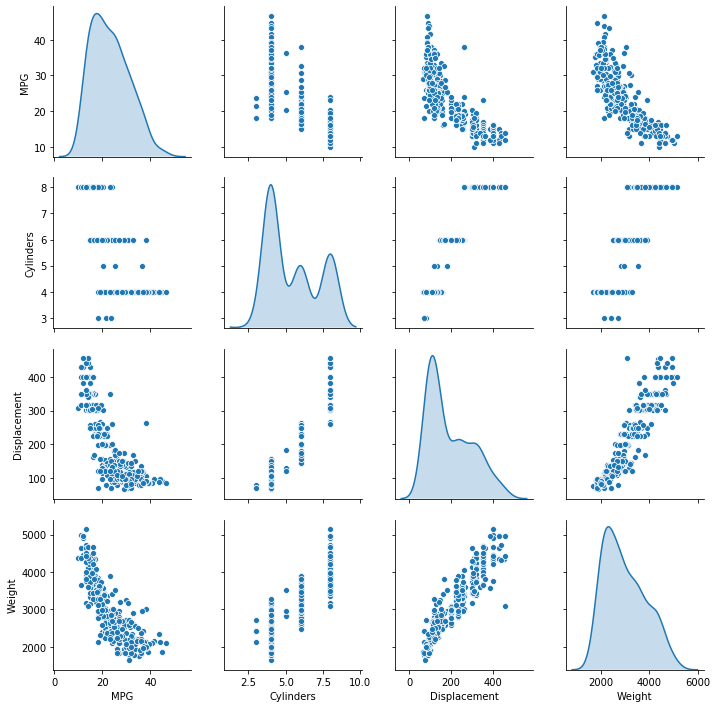

In [142]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics:

In [143]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [144]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [145]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [146]:
len(train_dataset.keys())

9

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

In [158]:
def build_model3():
    model = Sequential()
    model.add(Dense(5, input_shape=[len(train_dataset.keys())]))
    model.add(Activation('sigmoid'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='sgd', metrics=['mae', 'mse'])
    return model

In [149]:
def build_model4():
    model = Sequential()
    model.add(Dense(64, input_shape=[len(train_dataset.keys())]))
    model.add(Activation('sigmoid'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(64))
    model.add(Activation('sigmoid'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='sgd', metrics=['mae', 'mse'])
    return model

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [159]:
model3 = build_model3()
model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 5)                 50        
_________________________________________________________________
activation_13 (Activation)   (None, 5)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 6         
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [152]:
example_batch = normed_train_data[:10]
example_result = model3.predict(example_batch)
example_result

array([[-0.4712393 ],
       [-0.38929135],
       [-0.0768264 ],
       [-0.5570691 ],
       [-0.02504296],
       [-0.23541465],
       [-0.01214244],
       [ 0.427609  ],
       [-0.26979926],
       [ 0.04622939]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [160]:
EPOCHS = 100

history = model3.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0)

Visualize the model's training progress using the stats stored in the `history` object.

In [161]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
95,6.663026,1.938406,6.663026,7.154696,1.9345767,7.1546965,95
96,6.654376,1.920569,6.654376,7.109596,1.9163964,7.1095963,96
97,6.610940,1.926447,6.610940,7.130486,1.9133772,7.1304855,97
98,6.635523,1.917893,6.635523,7.088134,1.9292765,7.0881343,98
99,6.735262,1.955557,6.735262,7.067638,1.9175957,7.067638,99


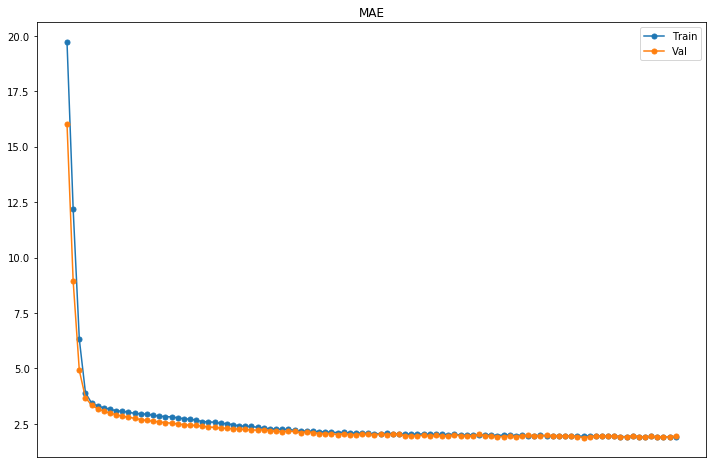

In [162]:
plotMeasure(hist['mae'], hist['val_mae'], 'MAE')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [163]:
model3 = build_model3()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model3.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:454.0836,  mae:19.7753,  mse:454.0836,  val_loss:303.5019,  val_mae:15.8298,  val_mse:303.5019,  
....................................................................

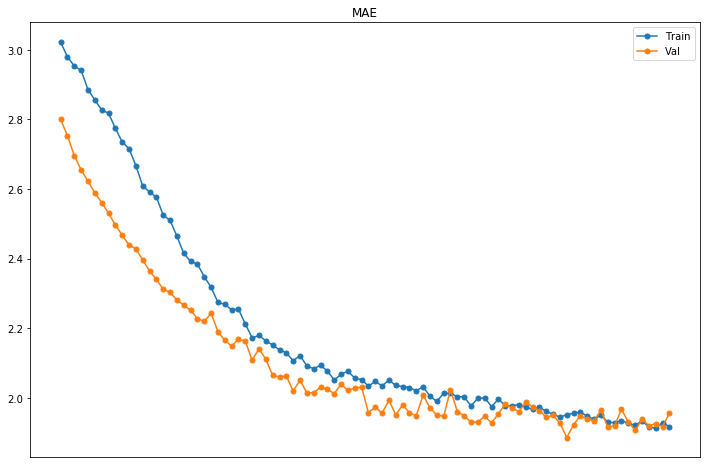

In [164]:
plotMeasure(hist['mae'][10:], hist['val_mae'][10:], 'MAE')

In [165]:
feature_weights_1 = model3.layers[0].get_weights()[0]

In [166]:
bias_1 = model3.layers[0].get_weights()[1]

In [172]:
bias_1

array([ 1.6163071 , -0.14932427, -1.9921192 ,  0.65699315, -0.22409958],
      dtype=float32)

In [167]:
feature_weights_2 = model3.layers[2].get_weights()[0]

In [168]:
bias_2 = model3.layers[2].get_weights()[1]

In [174]:
layer = 1
feature = 1
print(feature_weights_1[feature])
print(bias_1)

[ 1.1511106  -0.28729865 -0.24618076 -0.8433725   0.43344462]
[ 1.6163071  -0.14932427 -1.9921192   0.65699315 -0.22409958]


In [176]:
layer = 2
unit = 0
print(feature_weights_2)
print(bias_2[unit])

[[7.121818 ]
 [5.3426266]
 [6.8531437]
 [5.637577 ]
 [4.815548 ]]
7.836896


Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [177]:
loss, mae, mse = model3.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Squared Error: {:5.2f}".format(mse))
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Squared Error:  7.03
Testing set Mean Abs Error:  1.91


### Make predictions

Finally, predict MPG values using data in the testing set:

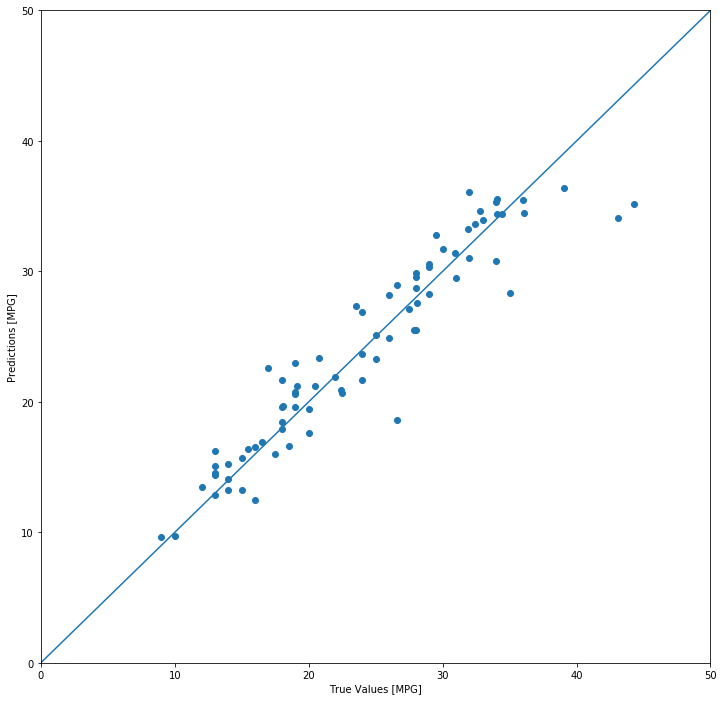

In [178]:
test_predictions = model3.predict(normed_test_data).flatten()

plt.figure(figsize=(12,12))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

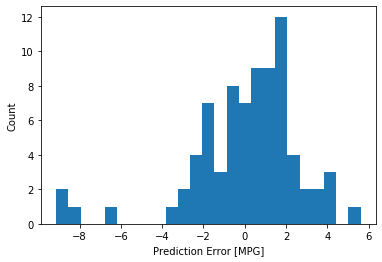

In [179]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.